This notebook creates and then trains naive templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [5]:
def log_norm(x,mode,sigma):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return f1(x)/f1(5000)

N = 8
n = 3
modes  = np.concatenate((np.linspace(5500,4600,n,endpoint=False),np.linspace(4600,1000,N-n)))
sigmas = np.concatenate((np.linspace(0.35,0.56,n,endpoint=False),np.linspace(0.56, 0.9,N-n)))

# save the templates as Seds
x = np.arange(10,15000,100,dtype=float)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i])
    naive_templates["N8-"+str(i+1)] = template
    
del N,n,modes,sigmas,x,i,template

Create training sets and plot them

In [6]:
%%time
training_sets = create_training_sets(galaxies,naive_templates,bandpass_dict)

CPU times: user 9.25 s, sys: 772 ms, total: 10 s
Wall time: 50.8 s


In [12]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('galaxies', 657120),
 ('Sed', 1064),
 ('interp1d', 1064),
 ('bandpass_dict', 656),
 ('naive_templates', 376),
 ('training_sets', 376),
 ('input', 184),
 ('create_training_sets', 144),
 ('get_bandpass_dict', 144),
 ('get_eff_wavelen', 144),
 ('log_norm', 144),
 ('train_templates', 144),
 ('np', 88),
 ('plt', 88),
 ('onecol', 24),
 ('twocol', 24)]

Number of galaxies in each training set:
[15431, 12380, 10966, 13897, 12513, 4699, 5796, 6298]


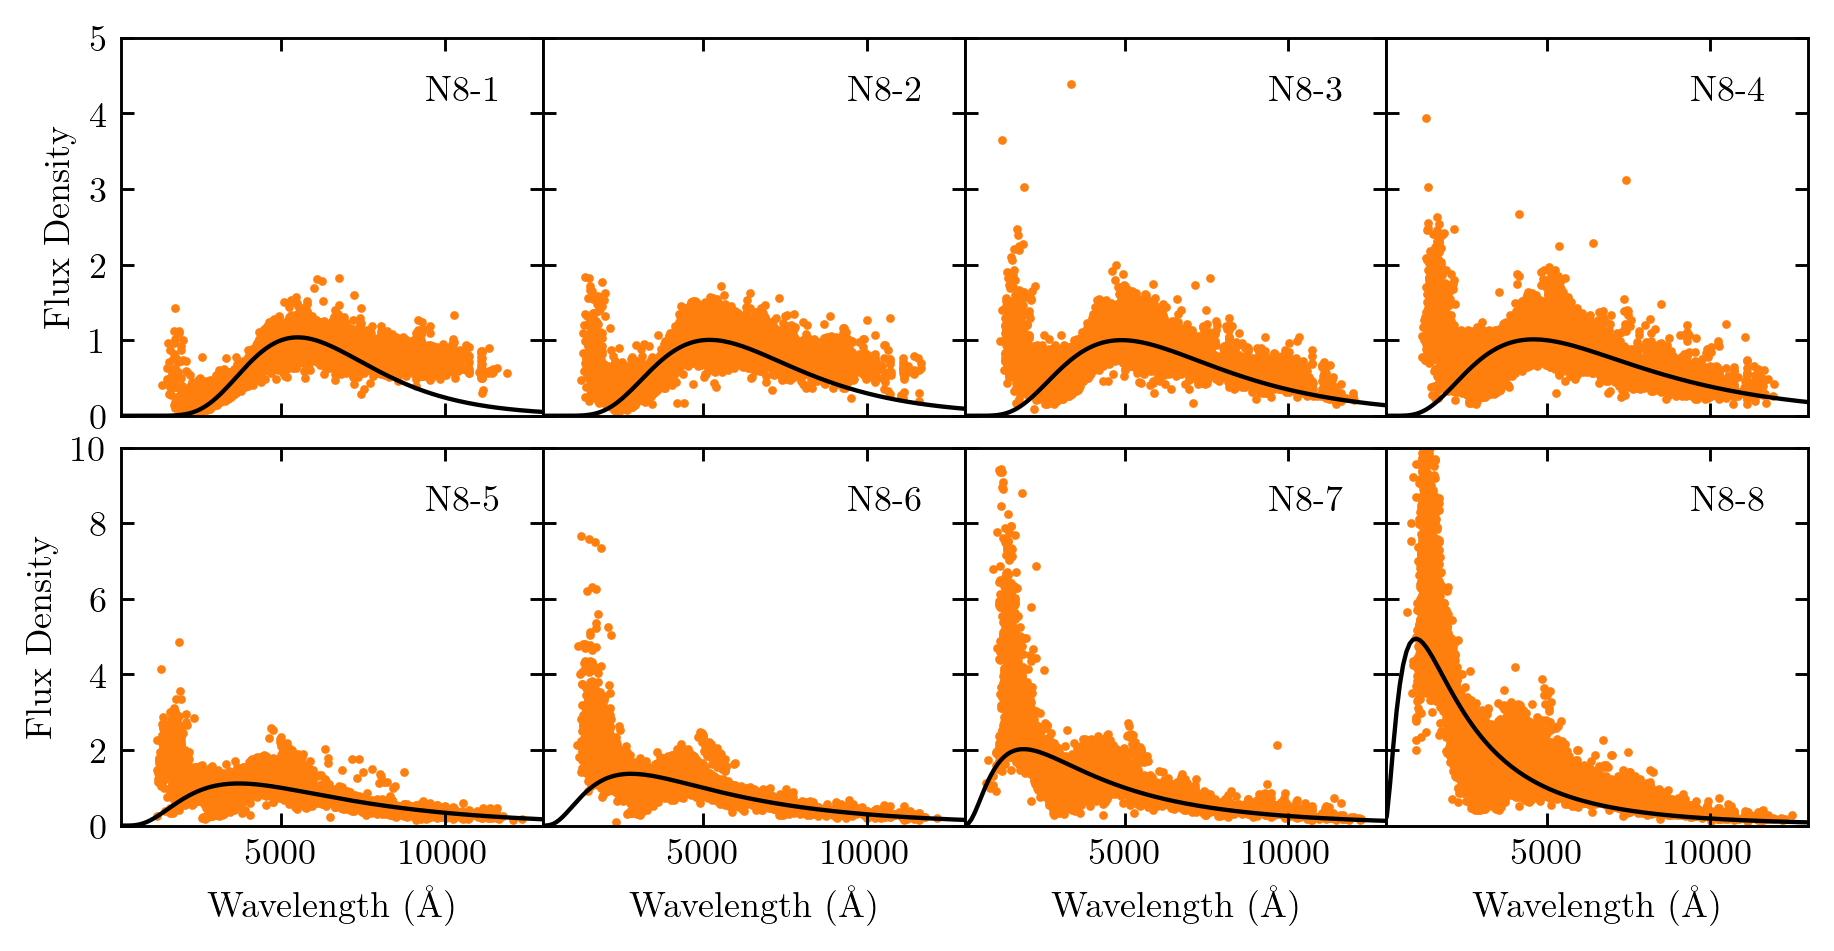

In [15]:
ncols = 4
nrows = 2
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols))

print("Number of galaxies in each training set:")
print([len(i) for i in training_sets.values()])

for key,ax in zip(training_sets.keys(),axes.flatten()):
    
    tset = training_sets[key]
    wavelen = [w for galaxy in tset for w in galaxy.wavelen]
    fluxes = [f for galaxy in tset for f in galaxy.fluxes]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    del tset, wavelen, fluxes
    
    template = naive_templates[key]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,key,transform=ax.transAxes,ha="right",va="top")
    
    ax.set_xlim(100,13000)

axes[0,0].set_ylim(0,5)
axes[1,0].set_ylim(0,10)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N8_untrained.png')

Now train the templates.

Note that during each round, it will print the wMSE for each template. The first number is the wMSE for the new photometry set. Each subsequent number is the new wMSE after perturbing the template. If only one number is printed, that means that the algorithm decided that the new photometry set isn't different enough to warrant perturbing the template again.

In [6]:
%%time
trained_templates, final_sets, history = train_templates(naive_templates, galaxies, bandpass_dict, w=0.5, dmse_stop=0.03, verbose=True)

Round 1
N8_1:   64.7   39.7   33.8   31.5   30.5   29.9  
N8_2:   97.2   64.4   59.9   58.3  
N8_3:   85.8   64.9   61.9   60.4  
N8_4:   88.2   67.1   63.5   61.6   60.4  
N8_5:   98.6   64.6   61.9   60.5  
N8_6:  260.0  171.8  162.1  157.5  
N8_7:  527.1  324.6  304.8  296.9  
N8_8: 1519.1  912.2  891.8  
Round 2
N8_1:   31.8   28.6   28.1  
N8_2:   46.6   40.7   40.0  
N8_3:   45.5   40.8   40.4  
N8_4:   37.2   34.9   34.4  
N8_5:   30.9   28.8   28.5  
N8_6:   72.4   66.0   65.3  
N8_7:  300.4  
N8_8:  661.2  570.3  557.3  
Round 3
N8_1:   29.3   27.7   27.4  
N8_2:   43.6   39.8   39.4  
N8_3:   39.6  
N8_4:   35.4  
N8_5:   30.5   29.4   29.3  
N8_6:   56.3   53.6   53.0  
N8_7:  133.4  120.5  119.3  
N8_8:  851.4  819.3  813.6  
Round 4
N8_1:   28.6   27.6   27.4  
N8_2:   39.3  
N8_3:   38.3   35.3   35.1  
N8_4:   34.4  
N8_5:   24.5   23.8   23.6  
N8_6:   60.8   59.2  
N8_7:   87.2   84.1   83.6  
N8_8:  934.5  913.3  
Round 5
N8_1:   28.6   27.8  
N8_2:   38.5  
N8_3:   3

Save the results!

In [12]:
"""for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = copy.copy(trained_templates[template].wavelen)
    y = copy.copy(trained_templates[template].flambda)
    # upsample to every 10 angstroms
    xnew = np.arange(x[0],x[-1],10)
    ynew = np.interp(xnew,x,y)
    for i in range(len(xnew)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(xnew[i],ynew[i]))
    file.close()
    
f = open("templates/N8_training_history.pkl","wb")
pickle.dump(history,f)
f.close()""";

Plot the trained templates

In [6]:
# Load the trained templates from files if you didn't run the training algorithm
trained_templates = dict()
for template in naive_templates:
    x,y = np.loadtxt('templates/'+template+'.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(trained_templates, galaxies, bandpass_dict)

Number of fluxes in each training set:
[44320, 41333, 42422, 53516, 60293, 80661, 63300, 25883]


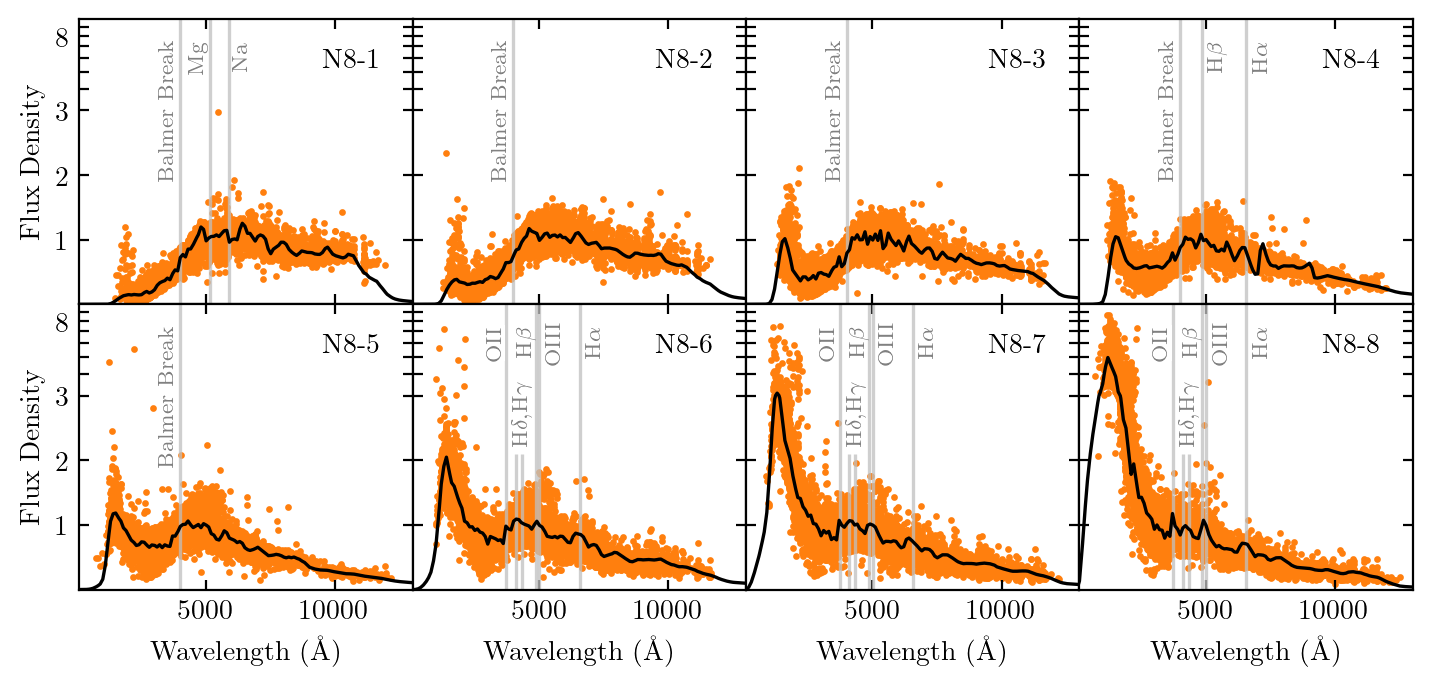

In [8]:
ncols = 4
nrows = int(len(trained_templates)/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.95))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in final_sets["N8_"+str(i+1)]]
    fluxes  = [row[1] for row in final_sets["N8_"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["N8_"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,"N8-"+str(i+1),transform=ax.transAxes,ha="right",va="top")
    

# Feature lines
axes_ = axes.flatten()
box_style = dict(facecolor='white', edgecolor='none', pad=0)
# Lyman Break
for i in [1,2,3,4,5]:
    axes_[i-1].vlines(4000,0,10,color='silver',alpha=0.75) # Lyman Break
    axes_[i-1].text(3900,3,"Balmer Break",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center',bbox=box_style)
# Mg and Na absorption
for i in [1]:
    axes_[i-1].vlines(5175,0,10,color='silver',alpha=0.75) # Mg
    axes_[i-1].text(5075,6,"Mg",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center',bbox=box_style)
    axes_[i-1].vlines(5894,0,10,color='silver',alpha=0.75) # Na
    axes_[i-1].text(5994,6,"Na",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center',bbox=box_style)
# Halpha
for i in [4,6,7,8]:
    axes_[i-1].vlines(6563,0,10,color='silver',alpha=0.75) # Halpha
    axes_[i-1].text(6763,6,r"H$\alpha$",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center',bbox=box_style)
# Hbeta
for i in [4]:    
    axes_[i-1].vlines(4861,0,10,color='silver',alpha=0.75) # Hbeta
    axes_[i-1].text(5061,6,r"H$\beta$",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center')    
for i in [6,7,8]:    
    axes_[i-1].vlines(4861,0,10,color='silver',alpha=0.75) # Hbeta
    axes_[i-1].text(4861,6,r"H$\beta$",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center')
# OIII
for i in [6,7,8]:
    axes_[i-1].vlines(5007,0,10,color='silver',alpha=0.75) # OIII
    axes_[i-1].text(5207,6,"OIII",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center')
# OII
for i in [6,7,8]:
    axes_[i-1].vlines(3727,0,10,color='silver',alpha=0.75) # OII
    axes_[i-1].text(3677,6,"OII",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center',bbox=box_style)
# Hdelta and Hgamma
for i in [6,7,8]:
    axes_[i-1].vlines(4102,0,2.1,color='silver',alpha=0.75) # Hdelta
    axes_[i-1].vlines(4340,0,2.1,color='silver',alpha=0.75) # Hgamma
    axes_[i-1].text(4352,2.2,r"H$\delta$,H$\gamma$",fontsize=8,rotation=90,
                    color='gray',ha='center',va='bottom',bbox=box_style)


for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
    ax.set_xlim(100,13000)
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    ax.set_yscale('symlog',linthreshy=3)
    ax.set_ylim(0,10)
    ax.set_yticks([1,2,3,4,5,6,7,8,9])
    ax.set_yticklabels([1,2,3,'','','','',8,''])
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N8_trained.png')

Plots of the training history

In [9]:
# load the history if you didnt just run the training
with open('templates/N8_training_history.pkl', 'rb') as input:
    history = pickle.load(input)

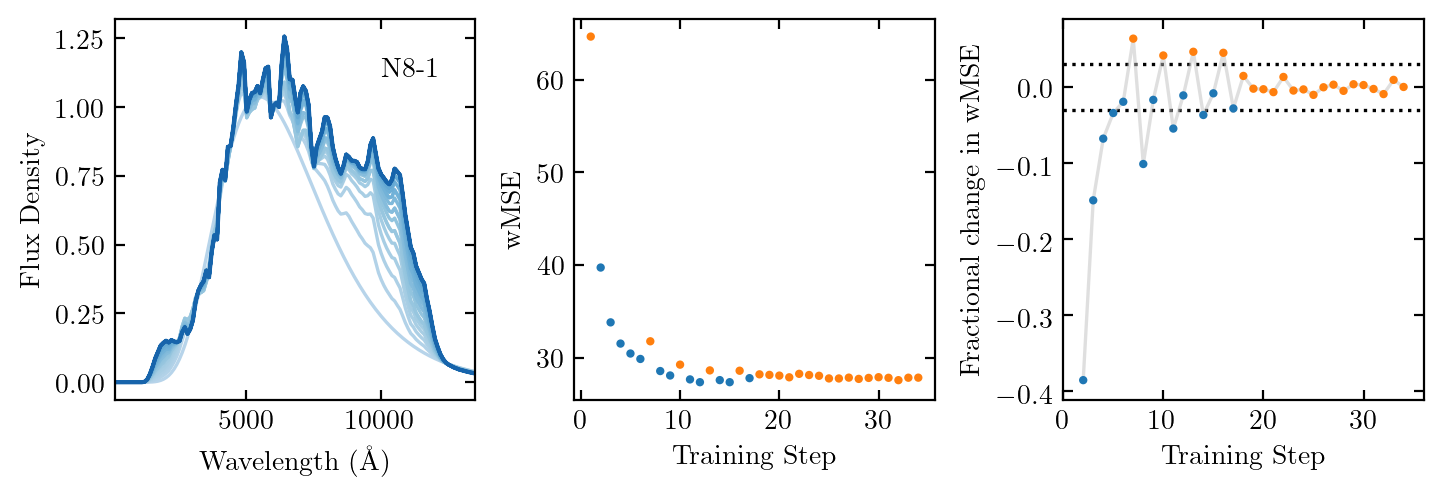

In [11]:
N = 1
name = "N8_"+str(N)

seds = []
mse = []
colors = []
for i in range(1,max(history[name].keys())+1):
    for j in range(0,max(history[name][i].keys())+1):
        seds.append(history[name][i][j]['sed'])
        mse.append(history[name][i][j]['mse'])
        if j == 0:
            colors.append('C1')
        else:
            colors.append('C0')
x = np.arange(1,len(mse)+1)

x2 = np.arange(1,len(mse))
dmse = [(mse[i+1]-mse[i])/mse[i] for i in range(len(x2))]

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(twocol,twocol/3),constrained_layout=True)

color_idx = np.linspace(0.3,0.8,len(seds))
for i,sed in enumerate(seds):
    lw = 1.2
    if i == len(seds)-1:
        lw = 1.5
    ax1.plot(sed.wavelen, sed.flambda, c=plt.cm.Blues(color_idx[i]), lw=lw)
    
ax1.text(0.9,0.9,"N8-"+str(N),transform=ax1.transAxes,ha="right",va="top")
    
ax2.scatter(x, mse, c=colors)

ax3.plot(x2+1, dmse, c='silver',zorder=0,alpha=0.5)
ax3.scatter(x2+1, dmse, color=colors[1:])
ax3.hlines(0.03,0,len(x2)+3,color='k',zorder=0,ls=':')
ax3.hlines(-0.03,0,len(x2)+3,color='k',zorder=0,ls=':')

ax1.set_xlim(100,13500)
#ax1.set_ylim(0,2)
ax1.set_xlabel("Wavelength (\AA)")
ax1.set_ylabel("Flux Density")

#ax2.set_xlim(0,25)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('wMSE')

ax3.set_xlim(0,len(x2)+3)
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Fractional change in wMSE')

#fig.savefig('plots/N8_1_training_history.pdf')
plt.show()